# Analyzing the India Covid-19 stats

## This notebook is highly motivated by https://github.com/k-sys/covid-19

Given the current focus on Covid-19, lets try and do some basic data analysis with whatever data is publicly available. As of now this notebook is India specific but of course the analysis techniques are applicable to any country, state, or geographic area as long as the data is suitably available.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output


## Read the csv file from an URL
Lets first get the data. The data from the https://www.covid19india.org/ project is available at https://api.covid19india.org/ and for the most part we will use the CSV files only. Kudos to this volunteer team that has done a wonderful job of verifying and then analysing the crowdsourced data of country wide Covid-19 related reports and statistics. 

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

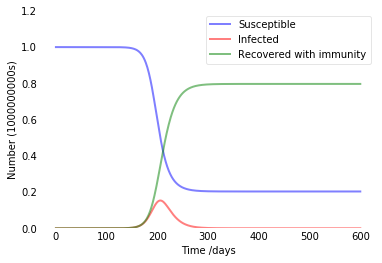

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 600, 600)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel(f'Number ({N}s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()



In [34]:
# if you have downloaded the file already
# filename = "confirmed.csv"

def skiplogic(index, compare):
    if index == 0:
       return False
    if index % 3 == compare:
       return False
    return True

# but it is more convenient if you can download it right now!
#filename = "http://api.covid19india.org/states_daily_csv/confirmed.csv"
filename = "https://api.covid19india.org/csv/latest/state_wise_daily.csv"
#data = pd.read_csv(filename) # from now on 'data' is god!
data_deceased = pd.read_csv(filename, skiprows= lambda x: skiplogic(x,0)) # from now on 'data' is god!
data_confirmed = pd.read_csv(filename, skiprows= lambda x: skiplogic(x,1)) # from now on 'data' is god!
data_recovered = pd.read_csv(filename, skiprows= lambda x: skiplogic(x,2)) # from now on 'data' is god!

print(data_recovered)

# Some global variables
# title fonts
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 20,
        }

# axis font
myfontsize=16

# standard deviation for gaussian distribution
std_dev=2

# days to use as window for rolling calculations
window=7


          Date     Status     TT  AN    AP  AR    AS   BR  CH   CT  ...   PB  \
0    14-Mar-20  Recovered      9   0     0   0     0    0   0    0  ...    0   
1    15-Mar-20  Recovered      4   0     0   0     0    0   0    0  ...    0   
2    16-Mar-20  Recovered      1   0     0   0     0    0   0    0  ...    0   
3    17-Mar-20  Recovered      1   0     0   0     0    0   0    0  ...    0   
4    18-Mar-20  Recovered      0   0     0   0     0    0   0    0  ...    0   
..         ...        ...    ...  ..   ...  ..   ...  ...  ..  ...  ...  ...   
122  14-Jul-20  Recovered  20977  20  1003   8   757  655  23   73  ...   77   
123  15-Jul-20  Recovered  20646   1   911   0   715  514  13   49  ...  204   
124  16-Jul-20  Recovered  22867   3  1015   0   666  568  17  127  ...  410   
125  17-Jul-20  Recovered  17476   0   905  22   551  896   4   61  ...   96   
126  18-Jul-20  Recovered  23552   0  1465  99  1060  774   5  146  ...   81   

      RJ  SK    TN    TG  TR    UP  UT 

## Bar plot of daily count

          Date     Status     TT  AN    AP  AR    AS    BR  CH   CT  ...   PB  \
0    14-Mar-20  Confirmed     81   0     1   0     0     0   0    0  ...    1   
1    15-Mar-20  Confirmed     27   0     0   0     0     0   0    0  ...    0   
2    16-Mar-20  Confirmed     15   0     0   0     0     0   0    0  ...    0   
3    17-Mar-20  Confirmed     11   0     0   0     0     0   0    0  ...    0   
4    18-Mar-20  Confirmed     37   0     0   0     0     0   0    0  ...    1   
..         ...        ...    ...  ..   ...  ..   ...   ...  ..  ...  ...  ...   
122  14-Jul-20  Confirmed  29917   5  1916  75   859  1432  12  114  ...  333   
123  15-Jul-20  Confirmed  32607   5  2432  29  1088  1320  19  177  ...  288   
124  16-Jul-20  Confirmed  35468   4  2593  52   892  1385  16  198  ...  295   
125  17-Jul-20  Confirmed  34820   0  2602  66  1218  1742  25  249  ...  348   
126  18-Jul-20  Confirmed  37407   0  3963  41  1117  1667  31  243  ...  350   

      RJ  SK    TN    TG   

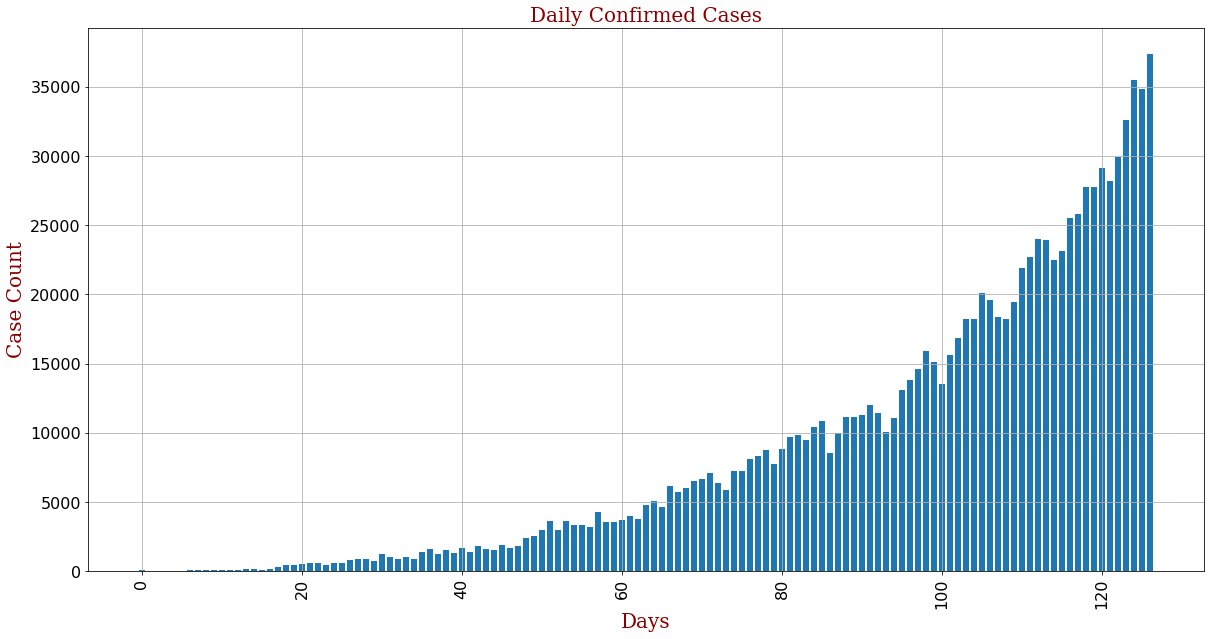

In [39]:
from scipy.stats import norm

confirmed = data_confirmed
print(confirmed)

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']
#xmin, xmax = 0, 80

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)
print(confirmed)

#mean,std=norm.fit(confirmed['TT'])
#print("mean: " + str(mean) + " std. dev.: " + str(std))

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)
plt.title('Daily Confirmed Cases', fontdict=font)
plt.xlabel('Days', fontdict=font)
plt.ylabel('Case Count', fontdict=font)
#plt.xlim(xmin, xmax)

#plt.plot(confirmed['TT'])
plt.bar(confirmed['TT'].index, confirmed['TT'])
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 1000)
#y = 150000*norm.pdf(x, 60, 15)
#print(x)
#print(y)
#plt.plot(x, y, 'r-')
plt.show()


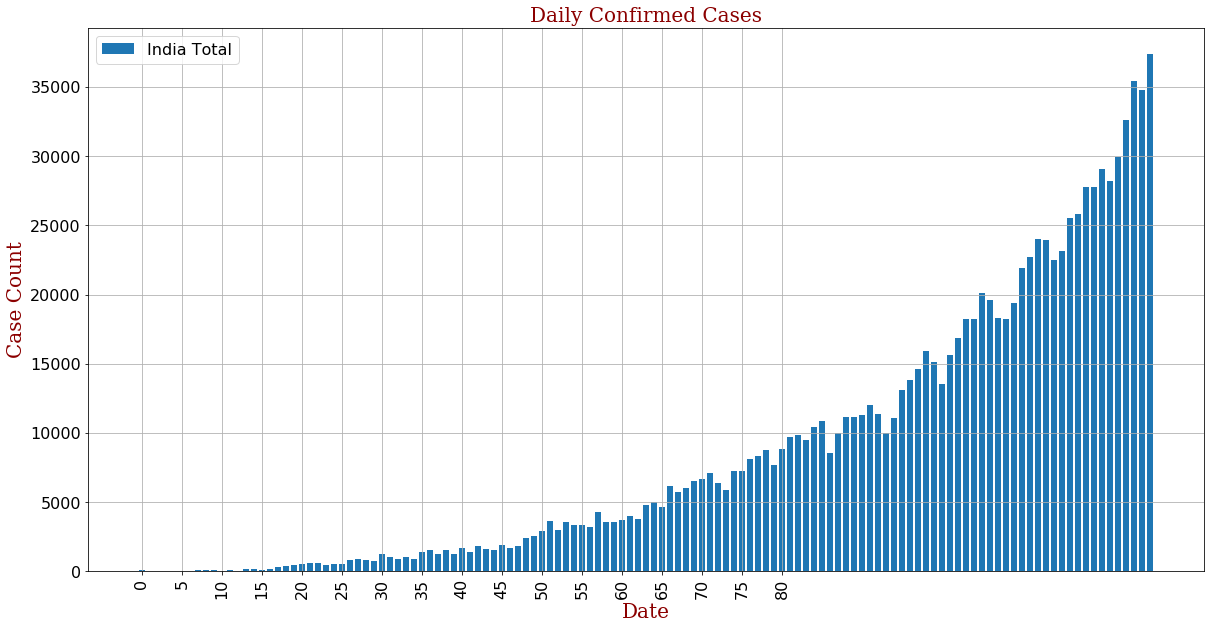

In [58]:
from scipy.stats import norm

confirmed = data_confirmed
#print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)
#plt.xlim(0, 200)

plt.title('Daily Confirmed Cases', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

#plt.plot(dates, confirmed['TT'], marker='o', markersize=10)
plt.bar(dates.index, confirmed['TT'])
plt.legend(['India Total'], loc=2, fontsize=myfontsize)
#xmin, xmax = plt.xlim()
#print("Xmin: " + str(xmin) + " Xmax: " + str(xmax))

#mean,std=norm.fit(confirmed['TT'])
#print("mean: " + str(mean) + " std. dev.: " + str(std))


#x = np.linspace(xmin, xmax, 100)
#y = norm.pdf(x, mean, std)
#plt.plot(x, y, marker="o")
plt.show()



## Warmup, try to get a plot of daily counts of some specific states and the country total.
This is just to get warmed up and really does not involve any analysis but just plots the data so that it can be visualized and hence better understood.

Index(['Date', 'Status', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN',
       'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD',
       'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN',
       'TG', 'TR', 'UP', 'UT', 'WB', 'UN'],
      dtype='object')


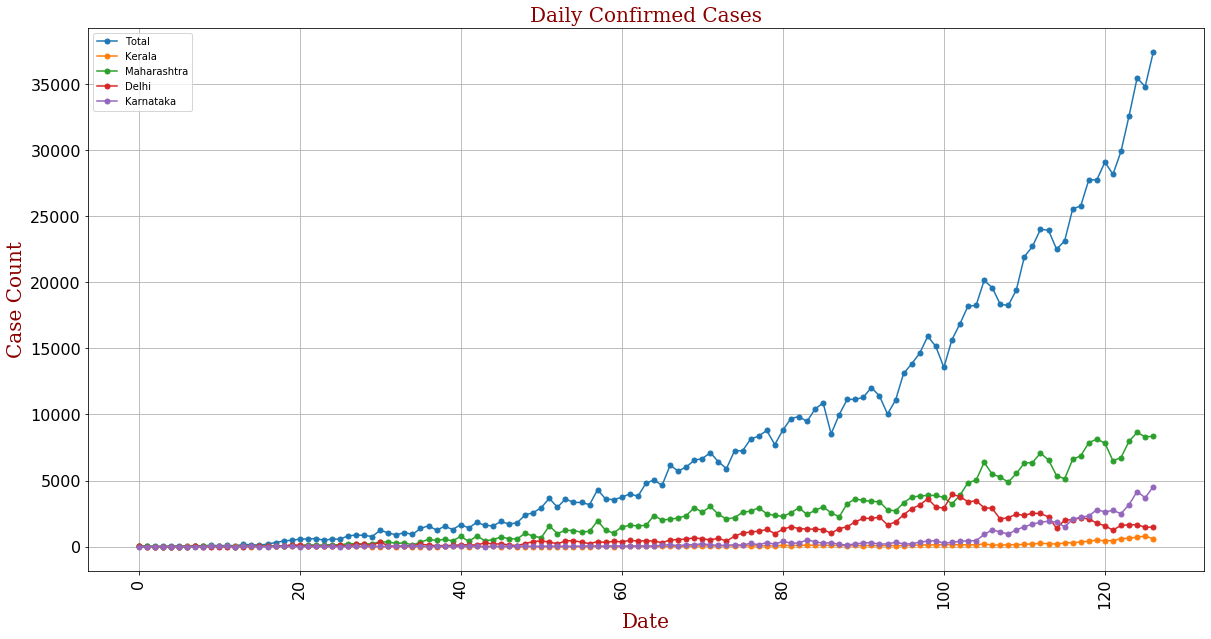

In [44]:
confirmed = data_confirmed
print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)

plt.title('Daily Confirmed Cases', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

plt.plot(dates.index, confirmed['TT'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['KL'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['MH'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['DL'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['KA'], marker='o', markersize=5)
plt.legend(['Total', 'Kerala', 'Maharashtra', 'Delhi', 'Karnataka'])

#confirmed.cumsum(axis=0)



## Daily count is too jittery. Lets try and smooth it - for one state. 
Daily count is fine, but then the daily samples are too jittery and the disease does not care much about dates. Hence, lets try and smooth the data assuming that, like many things in life, the data follows a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). We can play around with the standard deviation but we stick with a standard deviation of 2 (the lower the standard deviation, the steeper the curve).

          TT   AN      AP    AR      AS      BR    CH     CT    DN   DD  ...  \
0       42.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
1       35.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
2       30.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
3       29.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
4       32.0  0.0     1.0   0.0     0.0     0.0   1.0    0.0   0.0  0.0  ...   
..       ...  ...     ...   ...     ...     ...   ...    ...   ...  ...  ...   
122  30912.0  4.0  2150.0  41.0   920.0  1293.0  18.0  166.0  19.0  0.0  ...   
123  32440.0  4.0  2394.0  47.0   990.0  1403.0  19.0  184.0  22.0  0.0  ...   
124  33689.0  3.0  2610.0  50.0  1034.0  1471.0  21.0  198.0  25.0  0.0  ...   
125  34799.0  2.0  2837.0  51.0  1063.0  1542.0  22.0  212.0  28.0  0.0  ...   
126  35624.0  1.0  3064.0  50.0  1097.0  1590.0  25.0  228.0  32.0  0.0  ...   

        PB     RJ    SK      TN      TG

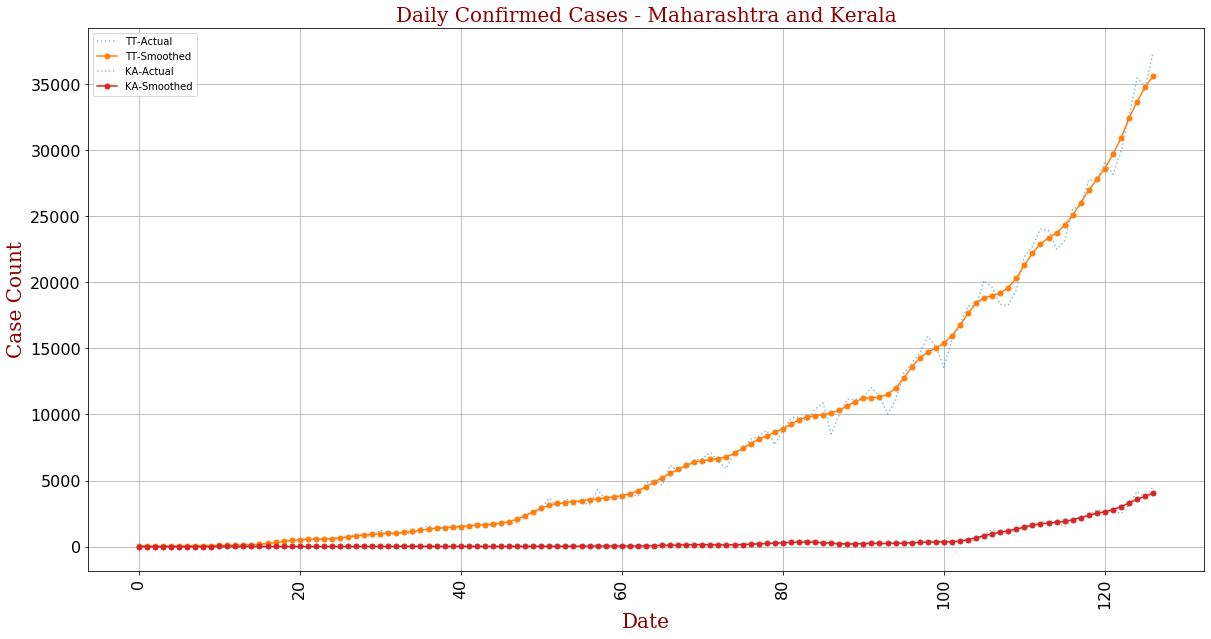

In [48]:
confirmed = data_confirmed
#print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)
smoothed = confirmed.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=std_dev).round()
print(smoothed)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)

plt.title('Daily Confirmed Cases - India and Karnataka', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

plt.plot(dates.index, confirmed['TT'], linestyle=':', alpha=0.5)
plt.plot(dates.index, smoothed['TT'], marker='.', markersize=10)
plt.plot(dates.index, confirmed['KA'], linestyle=':', alpha=0.5)
plt.plot(dates.index, smoothed['KA'], marker='.', markersize=10)

plt.legend(['TT-Actual', 'TT-Smoothed', 'KA-Actual', 'KA-Smoothed'])




Well I lied! I said one state but plotted for two but then anything to do with epidemics, has to have a plot for Kerala :-)

## Function to plot.
Just like any programming, one soon realizes that there are pieces of code that will be repeated a lot, and that would be perfect for writing a function for.

In [50]:
def plot_states(dates, inputdata, index_list, legend_list, title, xlabel, ylabel,legend_loc=2):
    fig=plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xticks(fontsize=myfontsize)
    plt.yticks(fontsize=myfontsize)
    plt.grid(True)
    plt.title(title, fontdict=font)
    plt.xlabel(xlabel, fontdict=font)
    plt.ylabel(ylabel, fontdict=font)
    
    markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'D']
    marker_count = len(markers)
    count=0
    for index in index_list:
        plt.plot(dates, inputdata[index], marker=markers[count%marker_count], markersize=10)
        count = count+1
    plt.legend(legend_list, loc=legend_loc)


## Cumulative, daily, and smoothed daily plots for the top 10 states with highest total cases.
It is not that useful to plot all states. For easier consumption, it is better to limit it to the top states, i.e., states which has the highest current number of covid positives to date.

In [60]:
confirmed = data_confirmed
print(confirmed.columns)
#print(confirmed.describe())

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date', 'Status'], axis=1)

smoothed = confirmed.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2).round()
#ewm = confirmed.ewm(span = 7).mean().round()

cumulative=confirmed.cumsum(axis=0)
print(cumulative)

# Lets get the 10 states with the highest number of cases
length=len(cumulative.index)
#print(length)
#last_row = cumulative.iloc[-1]
#print(last_row)
#print(cumulative.tail(1))

# sort using column values in the last row
cumulative = cumulative.sort_values(by=length-1, axis=1, ascending=False)
print("Contents of Sorted Dataframe based on a single row index label " + str(length-1))
top_ten = cumulative[cumulative.columns[1:11]]
top_5 = cumulative[cumulative.columns[1:6]]

Index(['Date', 'Status', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN',
       'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD',
       'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN',
       'TG', 'TR', 'UP', 'UT', 'WB', 'UN'],
      dtype='object')
          TT   AN     AP   AR     AS     BR   CH    CT   DN  DD  ...    PB  \
0         81    0      1    0      0      0    0     0    0   0  ...     1   
1        108    0      1    0      0      0    0     0    0   0  ...     1   
2        123    0      1    0      0      0    0     0    0   0  ...     1   
3        134    0      1    0      0      0    0     0    0   0  ...     1   
4        171    0      1    0      0      0    0     0    0   0  ...     2   
..       ...  ...    ...  ...    ...    ...  ...   ...  ...  ..  ...   ...   
122   937461  171  33019  462  18565  18853  600  4379  543   0  ...  8511   
123   970068  176  35451  491  19653  20173  619  4556  560   0  ...  879

## Now lets plot the cumulative, daily, and smoothed daily for the top 10 states

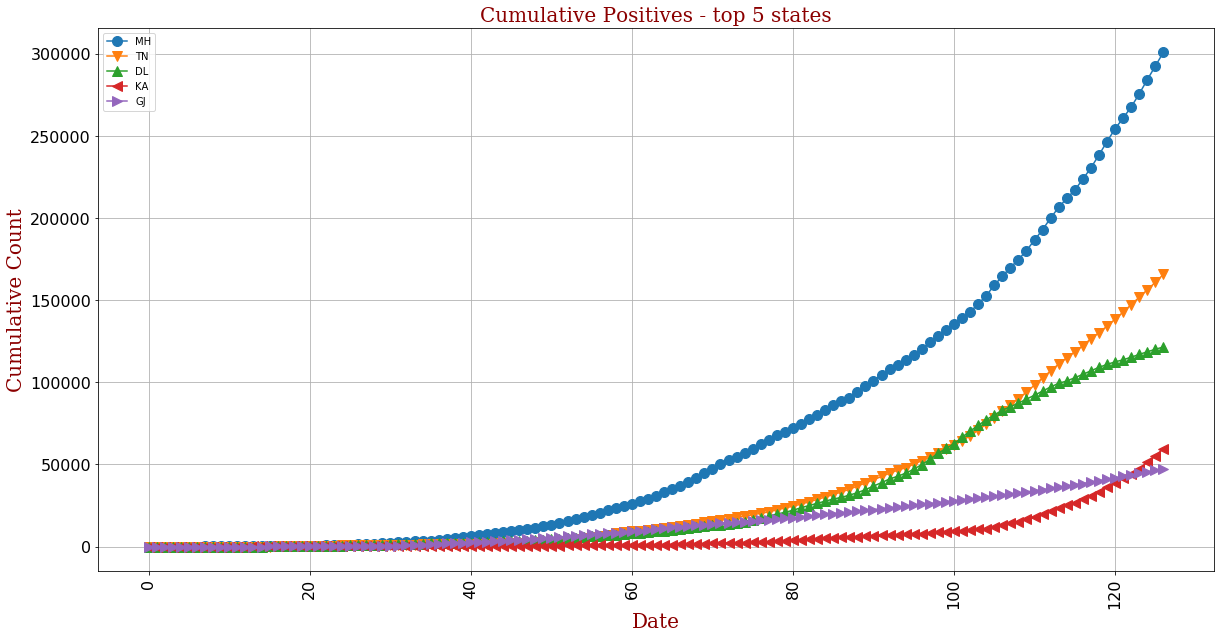

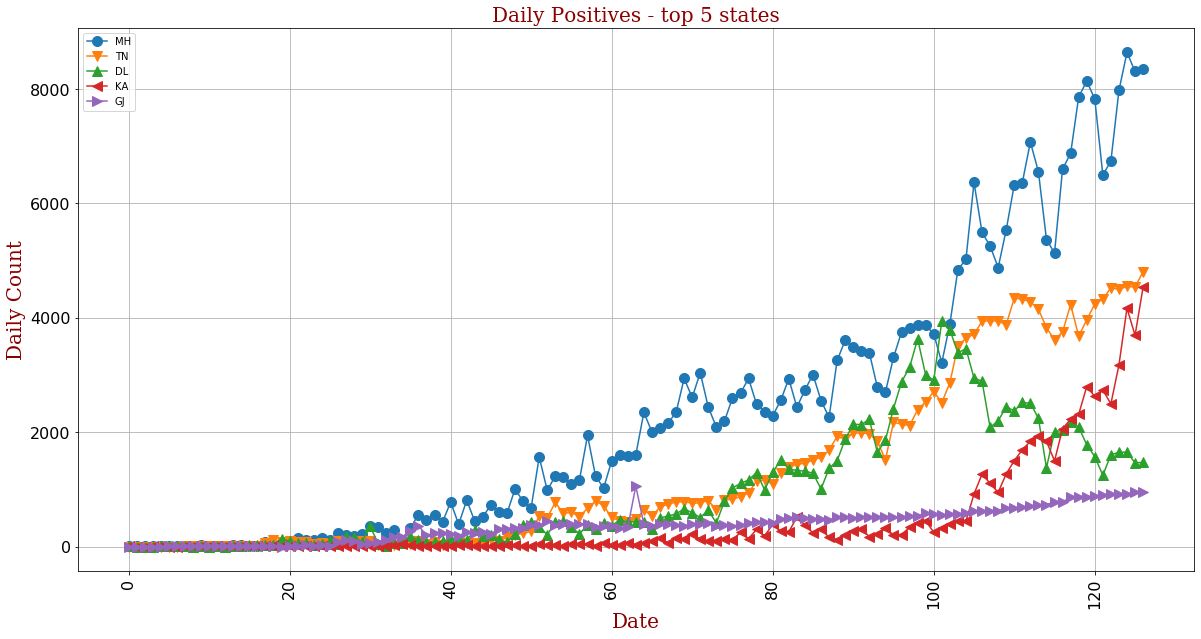

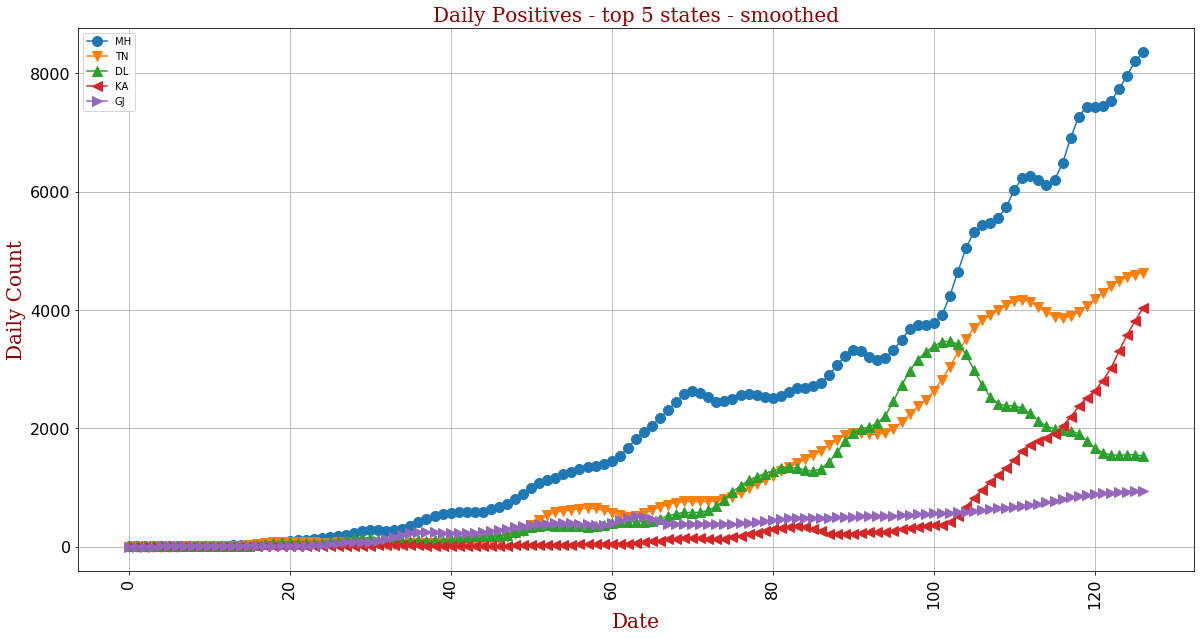

In [61]:
index_list = top_5.columns
legend_list = index_list
plot_states(dates.index, cumulative, index_list, legend_list, 'Cumulative Positives - top 5 states', 'Date', 'Cumulative Count')
plot_states(dates.index, confirmed, index_list, legend_list, 'Daily Positives - top 5 states', 'Date', 'Daily Count')
plot_states(dates.index, smoothed, index_list, legend_list, 'Daily Positives - top 5 states - smoothed', 'Date', 'Daily Count')
#plot_states(dates, ewm, index_list, legend_list, 'Daily Positives - top 10 states - ewm', 'Date', 'Daily Count')

## Well and good till now but lets try to get some idea of $R_0$ (R-nought)

$R_0$ is a widely accepted measure of how infectious a disease is.
Simply speaking $R_0 = \frac{\text{New cases}}{\text{Existing cases}}$ but the calculation gets complicated. 

Lets start simple. Lets try to calculate the daily $R_0$ as $\frac{\text{new cases today}}{\text{cumulative count till yesterday}}$ and lets see how that looks like. This is probably **incorrect** since it assumes that *all* positive cases in the past has an impact on the daily increase. In reality, once a person is positive, the person is put in hospital and his chances of spreading it to others is very low since hospital takes a lot of precaution. However, we know that even that is not true because we have seen healthcare staff testing positive as well. In short, reality is somewhat more complicated.

       KA     KA        KA
0       6      6       inf
1       0      6  0.000000
2       1      7  0.166667
3       2      9  0.285714
4       5     14  0.555556
..    ...    ...       ...
122  2496  44077  0.060027
123  3176  47253  0.072056
124  4169  51422  0.088227
125  3693  55115  0.071818
126  4537  59652  0.082319

[127 rows x 3 columns]


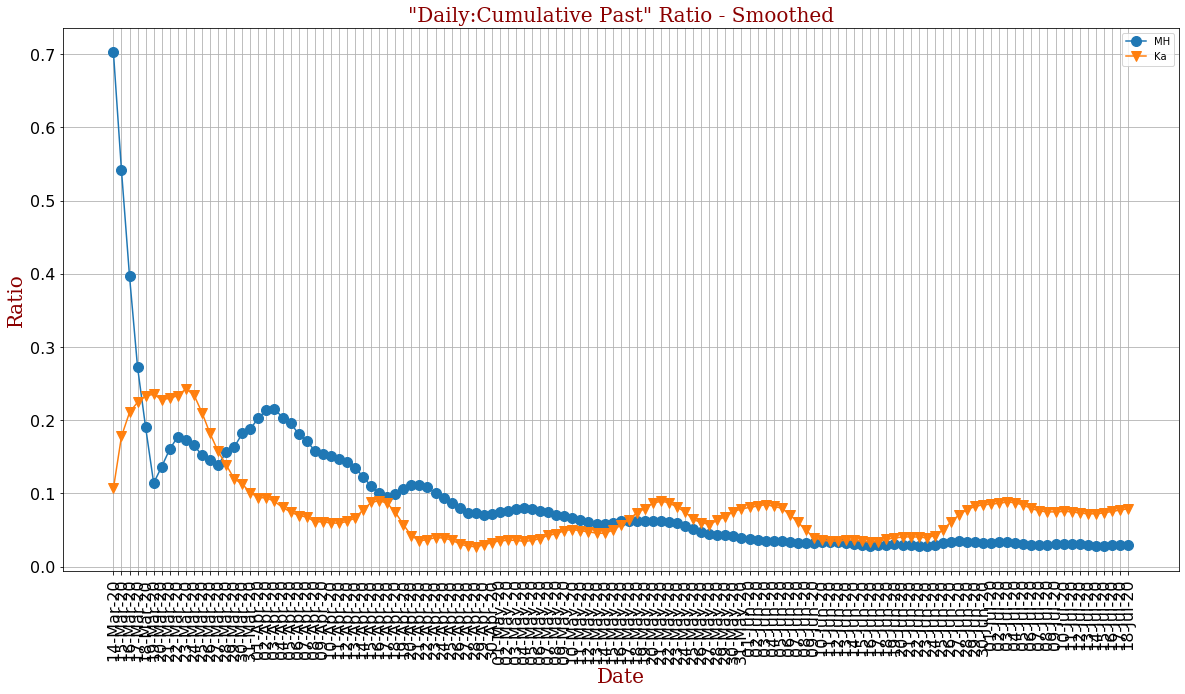

In [62]:
r0_min = confirmed/(cumulative-confirmed)
state='KA'
print(pd.concat([confirmed[state], cumulative[state],r0_min[state]], axis=1, sort=False))
#plot_states(dates, r0_min, index_list, legend_list, '"Daily:Cumulative Past" Ratio', 'Date', 'Ratio', legend_loc=1)

smoothed_r0_min = r0_min.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2)
index_list = ['MH', 'KA']
legend_list = ['MH', 'Ka']
plot_states(dates, smoothed_r0_min, index_list, legend_list, '"Daily:Cumulative Past" Ratio - Smoothed', 'Date', 'Ratio', legend_loc=1)


Clearly, if we assume that *all* positive cases in the past have contributed to the new cases today, this will give the most conservative estimate of $R_0$ since existing cases are way more than daily increase, especially as more and more days go by.

So lets be a little more realistic and assume that today's case could have been due to infections from the +ve cases from the past *window* days. This would be a more realistic *minimum* value for $R_0$. 

    KL         KL        KL
0   19        NaN       NaN
1    5        NaN       NaN
2    3        NaN       NaN
3    0        NaN       NaN
4    0        NaN       NaN
5    1        NaN       NaN
6   12  16.350901  0.733905
7   12  15.499549  0.774216
8   15  24.712075  0.606991
9   28  41.660689  0.672096
10  14  57.961940  0.241538
11   9  69.316198  0.129840
12  19  76.393781  0.248711
13  39  83.831704  0.465218
14   6  85.577654  0.070112
15  20  89.073783  0.224533
16  32  93.585825  0.341932
17   7  94.194820  0.074314
18  24  95.395349  0.251585
19  21  93.502484  0.224593
20   9  86.157371  0.104460
21  11  83.641897  0.131513
22   8  74.026048  0.108070
23  13  63.141931  0.205885
24   9  57.338021  0.156964
25   9  49.837052  0.180589
26  12  46.950762  0.255587
27   7  46.389289  0.150897
28  10  45.506793  0.219747
29   2  42.513820  0.047044
30   3  36.982599  0.081119
31   8  32.559524  0.245704
32   1  26.790902  0.037326
33   7  23.041941  0.303794
34   1  20.559941  0

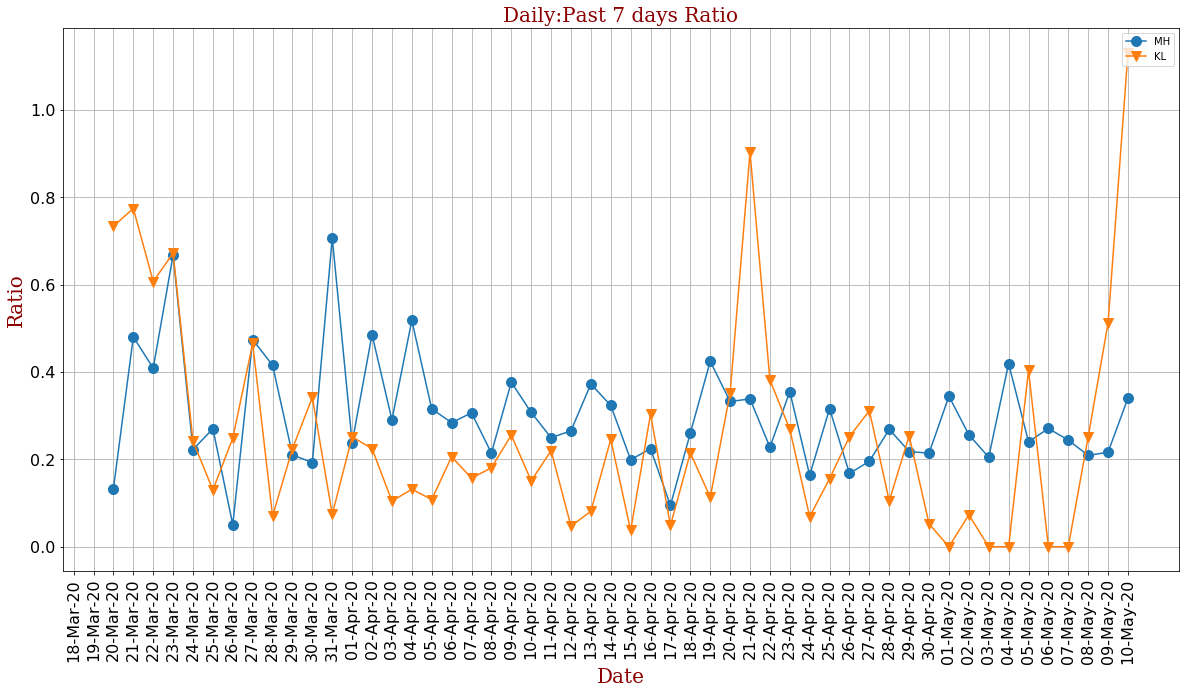

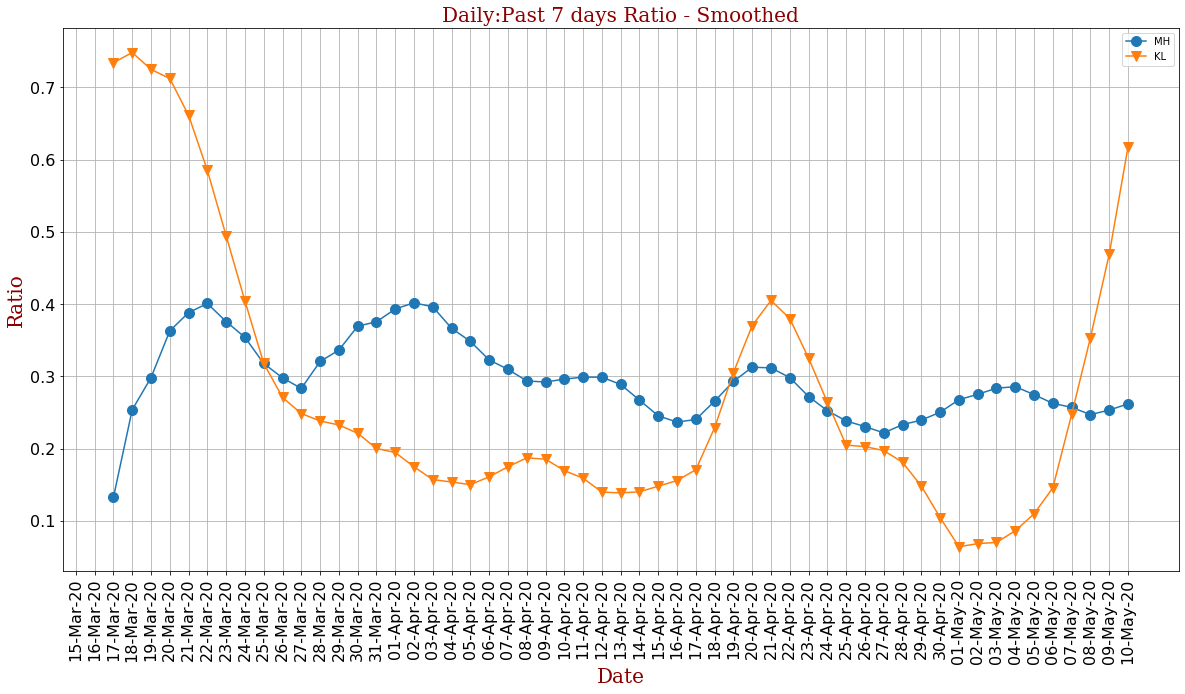

In [17]:
rolling = confirmed.rolling(window, win_type='gaussian', min_periods=window).sum(std=2)
r0_min = confirmed/rolling
state='KL'
print(pd.concat([confirmed[state], rolling[state], r0_min[state]], axis=1, sort=False))

smoothed_r0_min = r0_min.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2)
index_list = ['MH', 'KL']
legend_list = ['MH', 'KL']
plot_states(dates, r0_min, index_list, legend_list, f'Daily:Past {window} days Ratio', 'Date', 'Ratio', legend_loc=1)
plot_states(dates, smoothed_r0_min, index_list, legend_list, f'Daily:Past {window} days Ratio - Smoothed', 'Date', 'Ratio', legend_loc=1)

Now lets try and calculate what the *maximum* value for $R_0$ might be. For that we say that today's cases infected all future cases in the next *window* days. Of course, the infections are assumed to have happened before today's cases were diagnosed as +ve since once someone is considered +ve they are in a hospital and chances of them infecting others is low (healthcare folks can still get infected).

    KL     KL          KL         KL
0   19   33.0    1.736842   9.270425
1    5   43.0    8.600000  10.899128
2    3   68.0   22.666667  23.704439
3    0   82.0         inf  34.819416
4    0   91.0         inf  44.855892
5    1  109.0  109.000000  43.288288
6   12  136.0   11.333333  33.590471
7   12  130.0   10.833333  23.464592
8   15  135.0    9.000000  16.472428
9   28  139.0    4.964286   9.493580
10  14  132.0    9.428571   9.281012
11   9  147.0   16.333333   9.955503
12  19  149.0    7.842105  10.077533
13  39  119.0    3.051282   9.836700
14   6  124.0   20.666667   9.623037
15  20  112.0    5.600000   8.668732
16  32   93.0    2.906250   7.881373
17   7   95.0   13.571429   7.287860
18  24   80.0    3.333333   6.165838
19  21   71.0    3.380952   6.165275
20   9   69.0    7.666667   6.166101
21  11   68.0    6.181818   5.874975
22   8   62.0    7.750000   5.936700
23  13   52.0    4.000000   5.619741
24   9   51.0    5.666667   5.083976
25   9   43.0    4.777778   4.566784
2

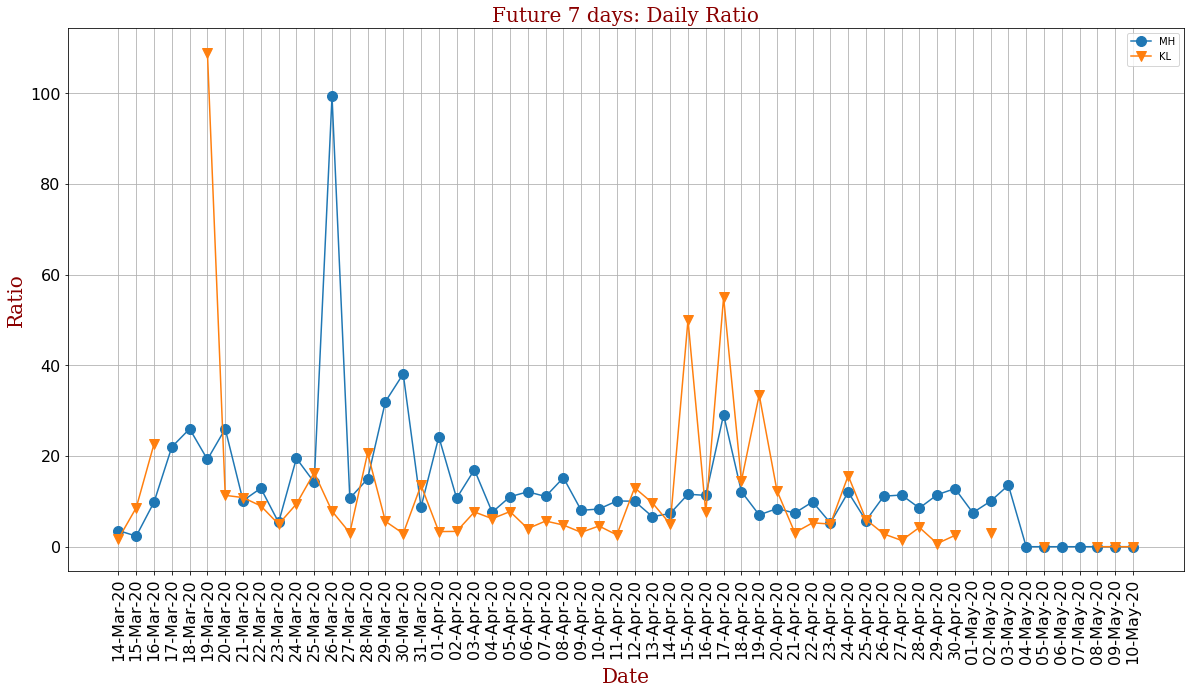

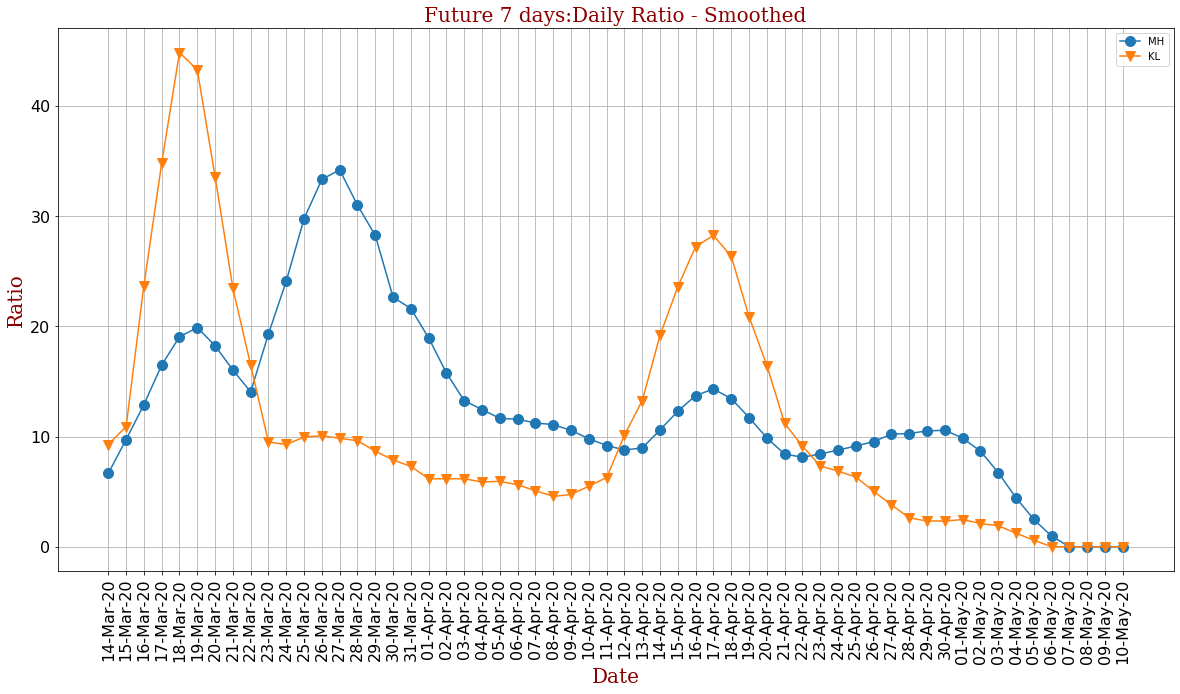

In [19]:
#rolling = confirmed.rolling(window, win_type='gaussian', min_periods=window).sum(std=2).shift(periods=-1*window,fill_value=0)
rolling = confirmed.rolling(window, min_periods=window).sum().shift(periods=-1*window,fill_value=0)
r0_max = rolling/confirmed
state='KL'
smoothed_r0_max = r0_max.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2)
print(pd.concat([confirmed[state], rolling[state], r0_max[state], smoothed_r0_max[state]], axis=1, sort=False))


index_list = ['MH', 'KL']
legend_list = ['MH', 'KL']
plot_states(dates, r0_max, index_list, legend_list, f'Future {window} days: Daily Ratio', 'Date', 'Ratio', legend_loc=1)
plot_states(dates, smoothed_r0_max, index_list, legend_list, f'Future {window} days:Daily Ratio - Smoothed', 'Date', 'Ratio', legend_loc=1)

Lets plot the min and max for the same state and check

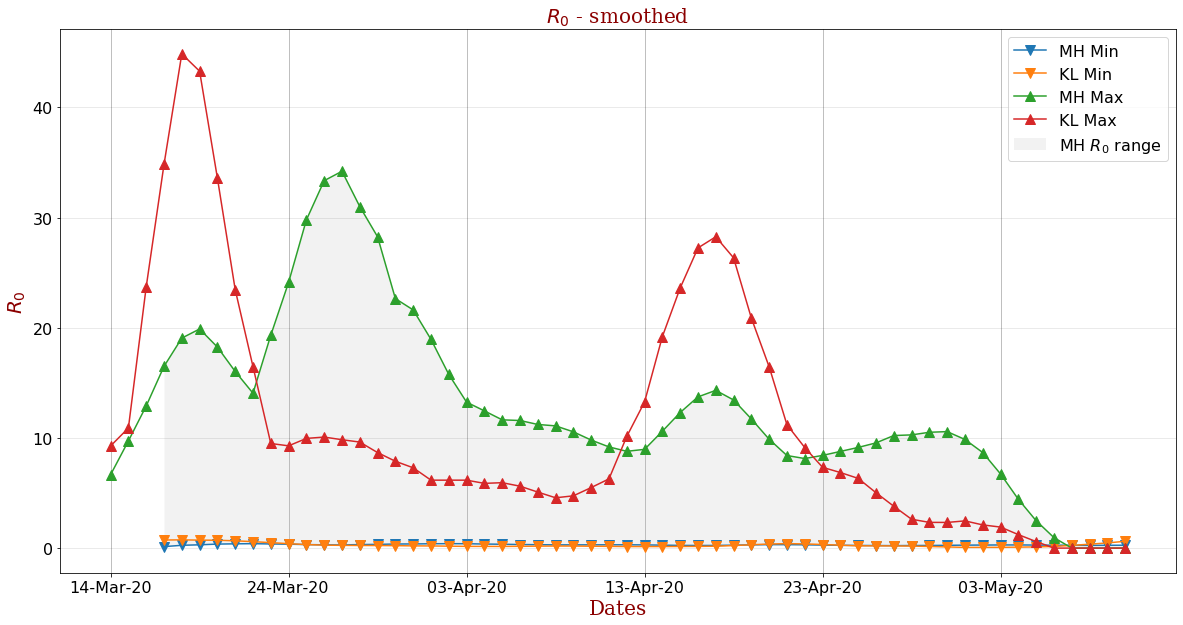

In [20]:
#fig=plt.figure(figsize=(20,10))

min_data = pd.concat([dates, smoothed_r0_min], axis=1, sort=False)
max_data = pd.concat([dates, smoothed_r0_max], axis=1, sort=False)

#    plt.xticks(rotation=90)
#    plt.xticks(fontsize=myfontsize)
#    plt.yticks(fontsize=myfontsize)
#    plt.grid(True)

ax = min_data.plot(x='date',
                   y=['MH', 'KL'],
                   marker='v',
                   label=['MH Min', 'KL Min'],
                   markersize=10,
                   figsize=(20,10),
                   fontsize=16,
                   grid=True)

ax = max_data.plot(ax=ax,
                   x='date',
                   y=['MH', 'KL'],
                   marker='^',
                   label=['MH Max', 'KL Max'],
                   markersize=10,
                   figsize=(20,10),
                   fontsize=16,
                   grid=True)

ax.fill_between(dates,max_data['MH'], min_data['MH'],
                color='k',
                alpha=.05,
                lw=0,
                label='MH $R_0$ range')

ax.legend(fontsize=16)
ax.set_xlabel('Dates', fontdict=font)
ax.set_ylabel('$R_0$', fontdict=font)
ax.set_title('$R_0$ - smoothed', fontdict=font)
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#ax.set_xticks(dates)
#ax.set_xticklabels(dates,rotation=90)





         date         MH
0   14-Mar-20   6.659307
1   15-Mar-20   9.725626
2   16-Mar-20  12.897219
3   17-Mar-20  16.491951
4   18-Mar-20  19.059500
5   19-Mar-20  19.888303
6   20-Mar-20  18.246408
7   21-Mar-20  16.032212
8   22-Mar-20  14.057316
9   23-Mar-20  19.321953
10  24-Mar-20  24.115465
11  25-Mar-20  29.787359
12  26-Mar-20  33.348979
13  27-Mar-20  34.204004
14  28-Mar-20  30.998761
15  29-Mar-20  28.253290
16  30-Mar-20  22.644183
17  31-Mar-20  21.617506
18  01-Apr-20  18.944876
19  02-Apr-20  15.763019
20  03-Apr-20  13.246263
21  04-Apr-20  12.454114
22  05-Apr-20  11.641279
23  06-Apr-20  11.581224
24  07-Apr-20  11.222381
25  08-Apr-20  11.092663
26  09-Apr-20  10.552325
27  10-Apr-20   9.805043
28  11-Apr-20   9.183736
29  12-Apr-20   8.783994
30  13-Apr-20   8.963053
31  14-Apr-20  10.608333
32  15-Apr-20  12.305359
33  16-Apr-20  13.232439
34  17-Apr-20  12.808387
35  18-Apr-20  10.482537
36  19-Apr-20   6.934017
37  20-Apr-20   3.639321
38  21-Apr-20   0.853927


array([-10.,   0.,  10.,  20.,  30.,  40.,  50.])

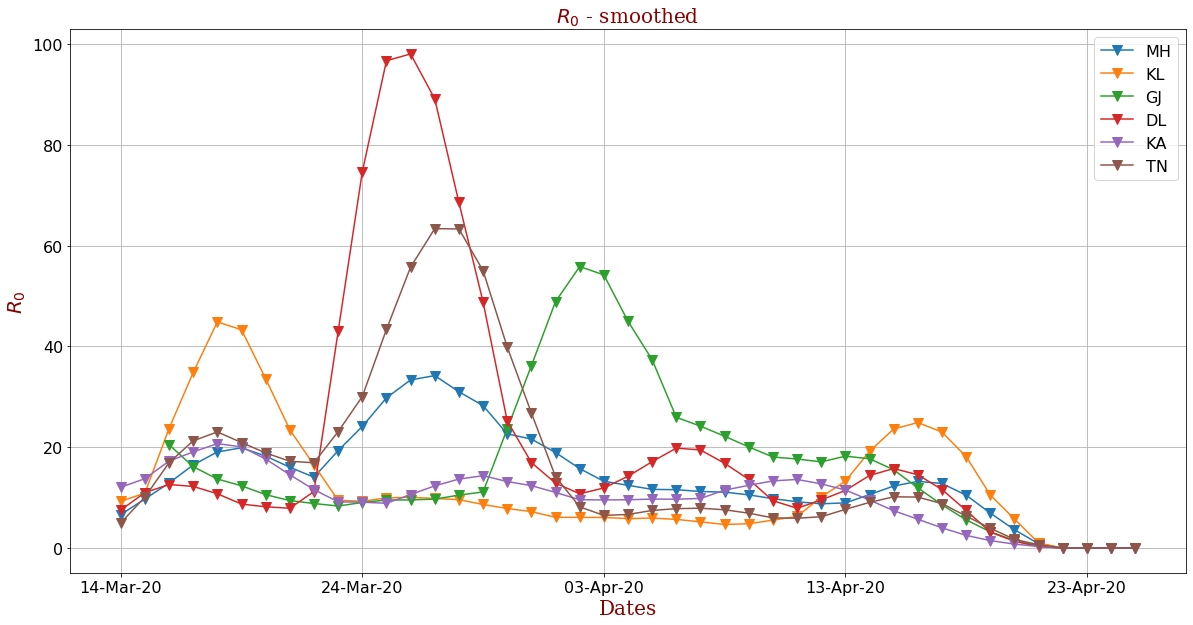

In [12]:
min_data = pd.concat([dates, smoothed_r0_min], axis=1, sort=False)
max_data = pd.concat([dates, smoothed_r0_max], axis=1, sort=False)
#max_data = pd.concat([dates, r0_max], axis=1, sort=False)

ax = max_data.plot(x='date',
                   y=['MH', 'KL', 'GJ', 'DL', 'KA', 'TN'],
                   marker='v',
                   #label=['MH', 'KL', 'GJ', 'DL', 'KA', 'TN'],
                   markersize=10,
                   figsize=(20,10),
                   fontsize=16,
                   grid=True
                  )

print(pd.concat([max_data['date'], max_data['MH']], axis=1, sort=False))

'''
ax = min_data.plot(ax=ax,
                   x='date',
                   y=['MH', 'KL'],
                   marker='^',
                   label=['MH Min', 'KL Min'],
                   markersize=10,
                   figsize=(20,10),
                   fontsize=16,
                   grid=True)

ax.fill_between(dates,max_data['MH'], min_data['MH'],
                color='k',
                alpha=.05,
                lw=0,
                label='MH $R_0$ range')


ax.set_xticks(dates)
ax.set_xticklabels(dates,rotation=90)
'''
#ax.set_xticks()
#ax.set_xticklabels(dates,rotation=90)
print(dates)
ax.legend(fontsize=16)
ax.set_xlabel('Dates', fontdict=font)
ax.set_ylabel('$R_0$', fontdict=font)
ax.set_title('$R_0$ - smoothed', fontdict=font)
#ax.set_ylim([0, 10])

ax.get_xticks()

